## SUMMARY

Statistics of activations matter -
* We often see a hockey stick in practice 
* This is b/c logits start at large values due to poorly initilized weights w/ extreme values
* The model spends the first few thousand iterations squashing weights to reasonable values

There is a risk of zero gradient w/ extreme values for logits -
* `Tanh` squashes to `1` and `-1`
* If the values of `h` are largely `1` or `-1` ...
* ... this is bad: recall the derivative of `tanh` `self.grad += (1 - t**2) * out.grad`
* So if `tanh` is 1 or -1, then the gradient vanishes b/c we multiply by zero

Use BN:
+ Want roughly gaussian activaitions 
+ For deep networks, we use a normalization layer (BN) to automate this  
+ Used following linear layers (CONV, FC)

Blocks stacked serially and involve motif:
* `Weight`: CONV (Linear w/ spatial structure of patches: `WX+B` on overlapping patches)
* `Normalization`: BATCH NORM
* `Non-linearity`: RelU

In [6]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()

In [120]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [7]:
# Build dataset
def build_dataset(words):  
  X, Y = [], []
  for w in words:
    #print(w)
    context = [0] * block_size
    # Iterate over all chars
    for ch in w + '.':
      ix = stoi[ch]
      # Input: Rolling window of context before char 
      X.append(context)
      # Target: Current char 
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# Context length: how many characters do we take to predict the next one
block_size = 3 
# Splits 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [111]:
# MLP
# Initialize the model
g = torch.Generator().manual_seed(2147483647)  

# Embedding matrix 
n_embed=10 # Dim of char embedding vector
n_hidden=200 # Number of neurons in hidden layer of MLP
C = torch.randn((27,n_embed),generator=g)

# Make params close to zero at initialization 
hidden_in=3*n_embed

# We use the Kaiming init for tanh non-linearity
W1 = torch.randn((hidden_in,n_hidden),generator=g) * (5/3)/(hidden_in**0.5)
b1 = torch.randn(n_hidden,generator=g) * 0.01
# Make params close to zero at initialization 
W2 = torch.randn((n_hidden,27),generator=g) * 0.01
b2 = torch.randn(27,generator=g) * 0

# BN params
bn_gain=torch.ones(1,n_hidden)
bn_bias=torch.zeros(1,n_hidden)
bn_mean_running=torch.zeros(1,n_hidden)
bn_std_running=torch.zeros(1,n_hidden)
parameters = [C,W1,b1,W2,b2,bn_gain,bn_bias]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

12297

Above we set the std of normal dist to `0.2`

In [103]:
(torch.randn(1000) *0.2).std()

tensor(0.2065)

In [104]:
gain = 5/3 # for tanh
gain / (hidden_in**0.5)

0.3042903097250923

We can find a principled way to set these parameters:

* Non-linearities are squashing: `RelU clamps everything < 0 to 0`. 
* TanH squeezes the tails in.
* Negative values are set to zero

Things that have made it less impt to calibrate the NN:

* Layers: Residual layers
* Better normalization: Batch norm
* Better optimiziers: RMSprop, ADAM
 
In practice:

* Normalize weights by squrt of `fan_in`

tensor(0.0040) tensor(1.0036)
tensor(0.0018) tensor(0.9908)


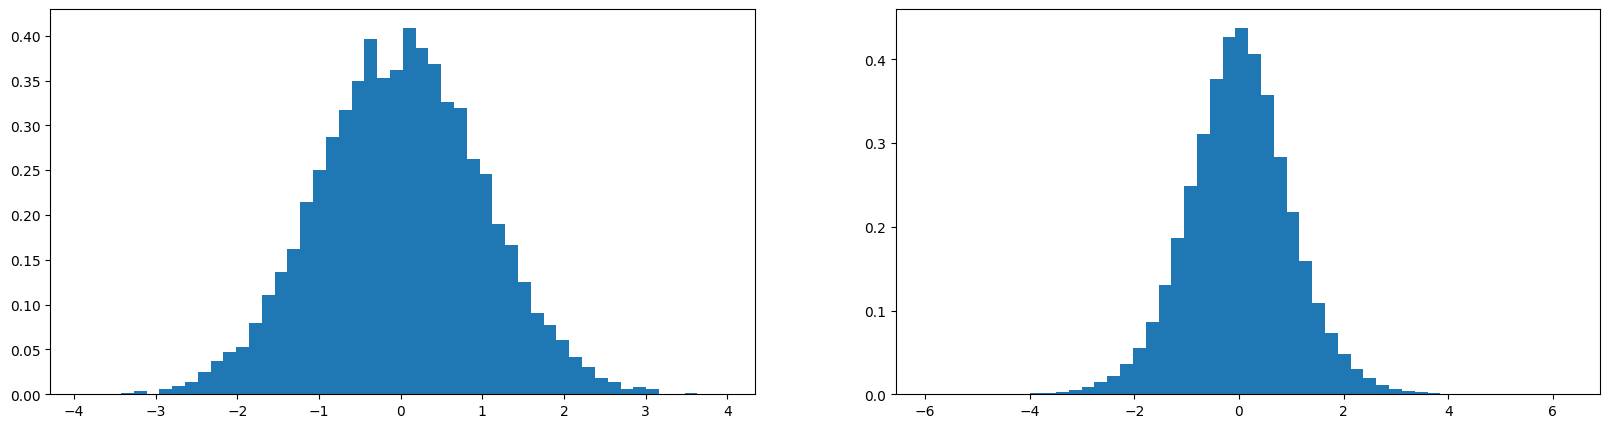

In [95]:
channel=10
x = torch.randn(1000,channel)
# Add a normalization 
fan_in=channel
w = torch.randn(10,200) / fan_in**0.5
y = x @ w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(1,2,2)
plt.hist(y.view(-1).tolist(),50,density=True);

We can also try `batch norm`:
    
* Use this to control the statistics of activations in the NN
* We don't want pre-activiations to be too small or too large
* Put after layers w/ multiplications, which will be `LINEAR` or `CONV` layers
* BN has parameters gain and bias, which are tuned w/ backprop 
* If also has buffers (updated during training)
* Calculating mean, std over batch and centering it to be unit gaussian and centering / scaling by gain / bias
 
Note: we don't need bias (`b1`) if using batch norm.

In [112]:
# Train
X = Xtr
Y = Ytr

# Params
max_steps=50000*3
batch_size=32

# Log
lossi=[]
stepi=[]

# Decay LR
lr_decay=[0.1,0.1,0.05]
lr_decay=[0.1]
for lr in lr_decay:

    # Iterate through batches 
    for i in range(max_steps):

        # Minibatch
        ix = torch.randint(0,X.shape[0],(batch_size,))

        # Embed each element in input
        emb=C[X[ix]] # [32, 3, 2]
        embcat=emb.view(emb.shape[0],-1)
        # Neural network 
        # h = torch.tanh(emb.view(-1,hidden_in) @ W1 + b1)
        hpreact=embcat @ W1 + b1
        # Let's make the Gaussian using BN!
        # At initialization: each Neuron firing values unit gaussian coming out 
        # During backprop: we tune bn_gain, bnbias
        bnmeani = hpreact.mean(0,keepdims=True)
        bnstdi = hpreact.std(0,keepdims=True)
        hpreact = bn_gain * (hpreact - bnmeani) / bnstdi + bn_bias
        
        # Update on the side of gradient based optimization
        # Keep track of these over time 
        with torch.no_grad():
            bn_mean_running = 0.999 * bn_mean_running + 0.001 * bnmeani
            bn_std_running = 0.999 * bn_std_running + 0.001 * bnstdi
        
        h=torch.tanh(hpreact)
        logits = h @ W2 + b2

        # Loss 
        loss_=F.cross_entropy(logits,Y[ix])

        # Backprop
        for p in parameters:
            p.grad = None
        loss_.backward()

        # LR
        lossi.append(loss_.log10().item())
        stepi.append(i)

        # Update
        for p in parameters:
            p.data += -lr*p.grad 

        # Track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss_.item():.4f}')
            
        # break

      0/ 150000: 3.2970
  10000/ 150000: 2.6139
  20000/ 150000: 2.1108
  30000/ 150000: 2.3819
  40000/ 150000: 2.5052
  50000/ 150000: 2.1785
  60000/ 150000: 2.4372
  70000/ 150000: 2.1322
  80000/ 150000: 2.2105
  90000/ 150000: 2.2672
 100000/ 150000: 1.9056
 110000/ 150000: 2.2675
 120000/ 150000: 2.3248
 130000/ 150000: 2.4389
 140000/ 150000: 2.3034


At initialization, we expect the model to assign equal probability to each of the 27 chars - 

* Probability for any char is `1/27`
* We use negative log liklihood
* `loss=-prob[torch.arange(num_chars),Y[ix]].log().mean()`

So, as a result the expected loss is a unform distribution on `1/27`: 

In [39]:
-torch.tensor(1/27.).log()

tensor(3.2958)

Loss is not too high if logits are near zero (or roughly equal). 

But, if logits go to `extreme` values then we have a problem, b/c the loss will blow up. 

In [40]:
# Toy example
# logits=torch.tensor([0.0,5.0,0.0,0.0])
logits=torch.randn(4) * 10
probs=torch.softmax(logits,dim=0)
loss=-probs[1].log()
probs,loss

(tensor([2.8281e-03, 1.1792e-07, 9.9703e-01, 1.3818e-04]), tensor(15.9533))

We see a hockey stick in practice - 

* This is b/c logits start at large values due to poorly initilized weights w/ extreme values
* The model spends the first few thousand iterations squashing weights to reasonable values
* Initial loss `27.2902` and converges to final loss of `1.6938`

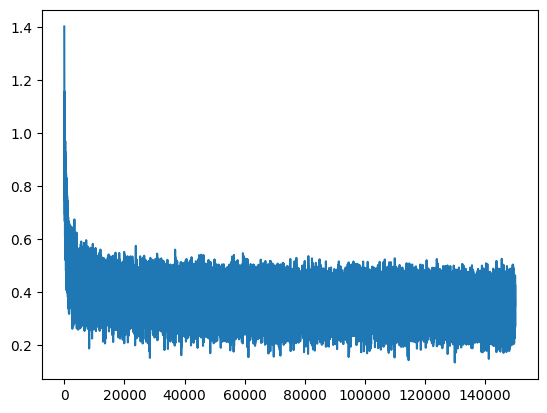

In [74]:
plt.plot(stepi,lossi)

If we initialize W2 and b2 to low values - 

* Initial loss `3.9892` and converges to final loss of `2.0054`

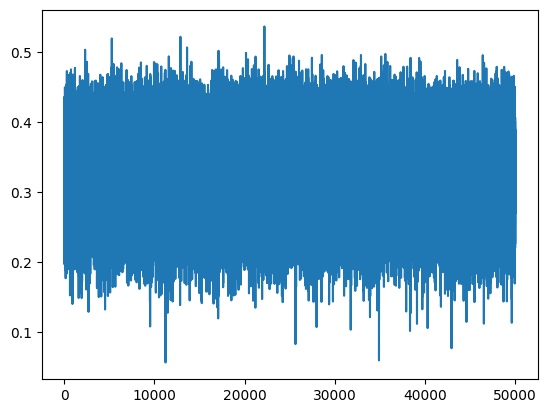

In [53]:
plt.plot(stepi,lossi)

Let's examine `Tanh` -

* `Tanh` squashes to `1` and `-1`
* Values of `h` are largely `1` or `-1`
* This is bad: recall the derivative of `tanh` `self.grad += (1 - t**2) * out.grad`
* So if `tanh` is 1 or -1, then the gradient vanishes b/c we multiply by zero 
* Closer to the tails, the gradient is squashed

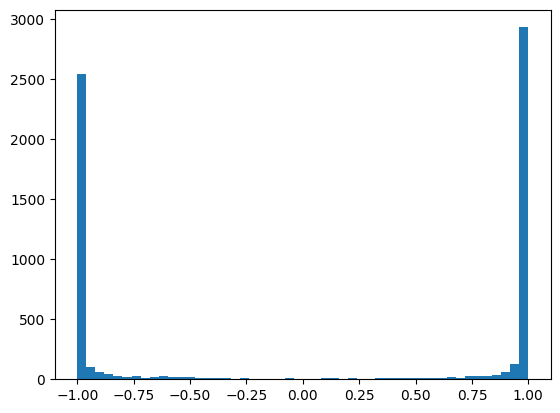

In [78]:
plt.hist(h.view(-1).tolist(),50);

Central problem is that these values are too large! 

We want `hpreact` to be close to zero.

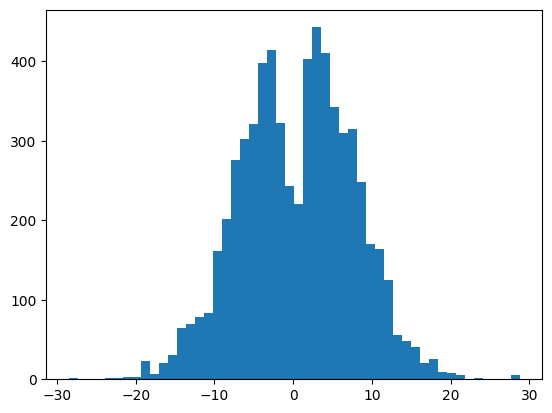

In [79]:
plt.hist(hpreact.view(-1).tolist(),50);

After we reduce the scale of `W1` and `b1` used to compute `hpreact`, we can see less extreme values.

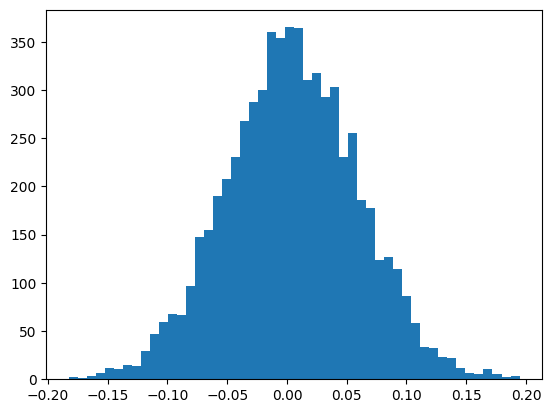

In [91]:
plt.hist(hpreact.view(-1).tolist(),50);

Visualize cases where the gradient will be destoyed: 

* Some neurons are dead at initialization: W and b are such that neuron is in a saturated output region 
* This means that changes to input do not affect out, meaning gradient zero
* We can see if this is trye for `h` - if all columns are white (1), then it's a dead neuron
* It will always fire 1 or -1, making the gradient squashed

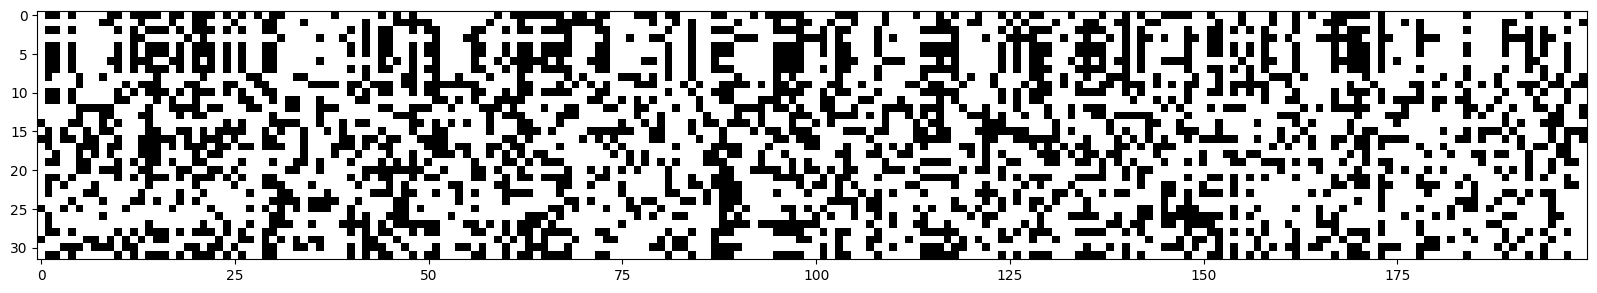

In [87]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

No neurons are saturated.

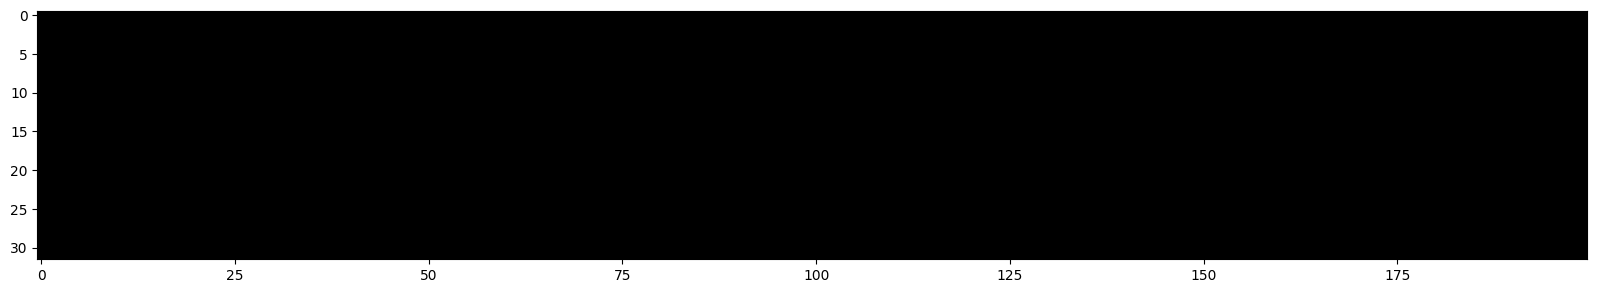

In [92]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

Example of BN in practice -

ResNet (https://pytorch.org/hub/pytorch_vision_resnet/)

Blocks stacked serially and involve motif:

* `Weight`: CONV (Linear w/ spatial structure of patches: `WX+B` on overlapping patches)
* `Normalization`: BATCH NORM
* `Non-linearity`: RelU

**Overall:**

1/ Statistics of activations matter.

2/ Reduce extreme values of init: 
+ Limit hockey-stick decline in loss
+ More steps doing useful work

3/ Control activaitions:
+ Want roughly gaussian activaitions 
+ For deep networks, we use a normalization layer (BN) to automate this  
+ Used following linear layers (CONV, FC)

Let's Pytorch-ify the code.

1/ `Linear Layer`

* Fan_in: # inputs
* Fan_out: # output
* Initialize: Gaussian w/ Kaiming initialization 

Recall:

* If logits start at large values due to poorly initilized weights ... 
* We spent the first few thousand iterations squashing weights to reasonable values ... 
* We also risk "dead neurons" that fail to update b/c the grad is zero at large values

Let's implement the modules ...

In [167]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
        
        # Initialize over sqrt of fan as normalization 
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
        
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
  def parameters(self):
        
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
        
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # Buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
  def __call__(self, x):
        
        # Calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # Update the buffers (not part of backprop)
        if self.training:
            # Context mamanger 
            # Do this, otherwise PyT will start building out a computational graph (expecting we will call grad)
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
  def parameters(self):
        
        return [self.gamma,self.beta]
    
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

We can stack these up as layers.

In [168]:
n_embd = 10 # char embedding
n_hidden = 100 # neurons in hidden layer
g = torch.Generator().manual_seed(2147483647)

In [169]:
C = torch.randn((vocab_size,n_embd),generator=g)

Add batchnorm after linear layers, but can also be added after non-linearities!

In [170]:
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),BatchNorm1d(vocab_size) 
]

In [171]:
with torch.no_grad():
    
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3
      
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47351


In [172]:
# Train
X = Xtr
Y = Ytr

# Params
max_steps=200000
batch_size=32

# Log
lossi=[]
ud = []

# Iterate through batches 
for i in range(max_steps):

    # Minibatch
    ix = torch.randint(0,X.shape[0],(batch_size,))

    # Embed each element in input
    emb=C[X[ix]] # [32, 3, 2]

    # Concat 
    x=emb.view(emb.shape[0],-1)

    # Forward 
    for layer in layers:
        x = layer(x)
    # Loss
    loss_=F.cross_entropy(x,Y[ix])

    # Backprop
    for layer in layers:
        # Keep gradient 
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    # Fill in gradients
    loss_.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad 

    # Track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss_.item():.4f}')
    lossi.append(loss_.log10().item())
    # Log 
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.3047
  10000/ 200000: 2.0424
  20000/ 200000: 2.4866
  30000/ 200000: 2.1854
  40000/ 200000: 1.9171
  50000/ 200000: 2.2777
  60000/ 200000: 2.3176
  70000/ 200000: 2.0453
  80000/ 200000: 1.7416
  90000/ 200000: 1.7888
 100000/ 200000: 1.6565
 110000/ 200000: 2.0495
 120000/ 200000: 2.3632
 130000/ 200000: 1.9492
 140000/ 200000: 2.3110
 150000/ 200000: 1.8985
 160000/ 200000: 1.7489
 170000/ 200000: 1.6340
 180000/ 200000: 1.9077
 190000/ 200000: 2.4633


Histogram of fwd pass activations - 

* Saturation defined as: `t.abs() > 0.97`
* First layer fairly saturated, but everything else stabilizies 
* Stabilizes b/c `gain` set to `5/3`

Remember - 

* `Tanh` is a squashing function!
* Gain is needed to re-expand and fight the squashing that occours when we normalize by sqrt of fan in

Before normalizers - 

* It was really hard to train NNs! 

Why non-linearity - 

* Linear sandwich w/o TanHl it's just a linear transformation (!)
* Non-linearity turns this into a general funtional that can learn many other functions

layer 1 (      Tanh): mean -0.07, std 0.87, saturated: 49.22%
layer 3 (      Tanh): mean -0.00, std 0.89, saturated: 54.78%
layer 5 (      Tanh): mean +0.00, std 0.90, saturated: 54.56%
layer 7 (      Tanh): mean -0.04, std 0.89, saturated: 52.59%
layer 9 (      Tanh): mean +0.01, std 0.82, saturated: 35.81%


Text(0.5, 1.0, 'activation distribution')

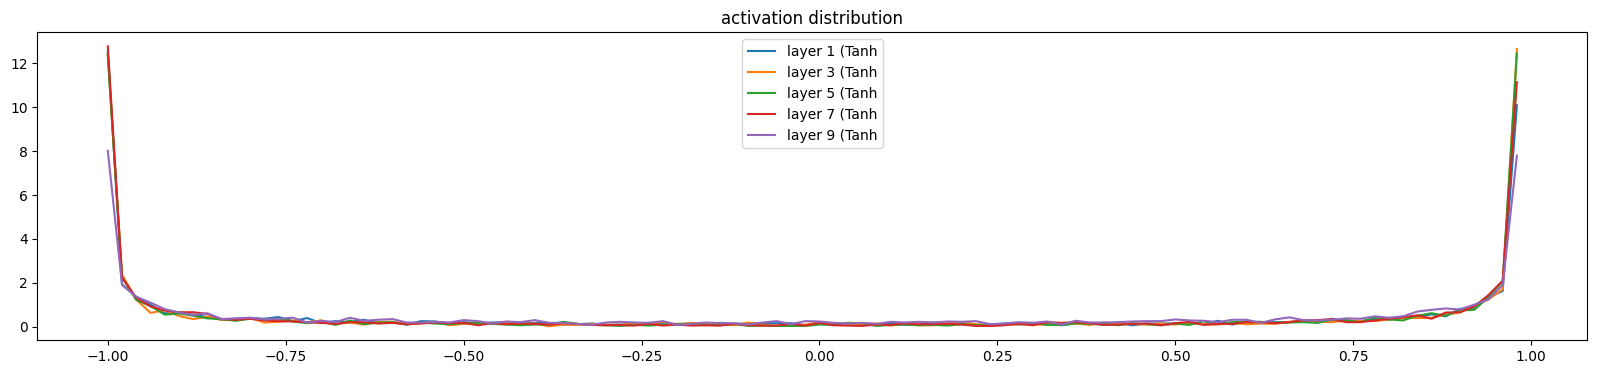

In [156]:
# Visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Ensure all layers have roughly the same gradient.

layer 1 (      Tanh): mean -0.000094, std 6.238816e-03
layer 3 (      Tanh): mean -0.000040, std 5.558089e-03
layer 5 (      Tanh): mean +0.000000, std 4.871769e-03
layer 7 (      Tanh): mean -0.000115, std 4.700585e-03
layer 9 (      Tanh): mean +0.000113, std 4.818713e-03


Text(0.5, 1.0, 'gradient distribution')

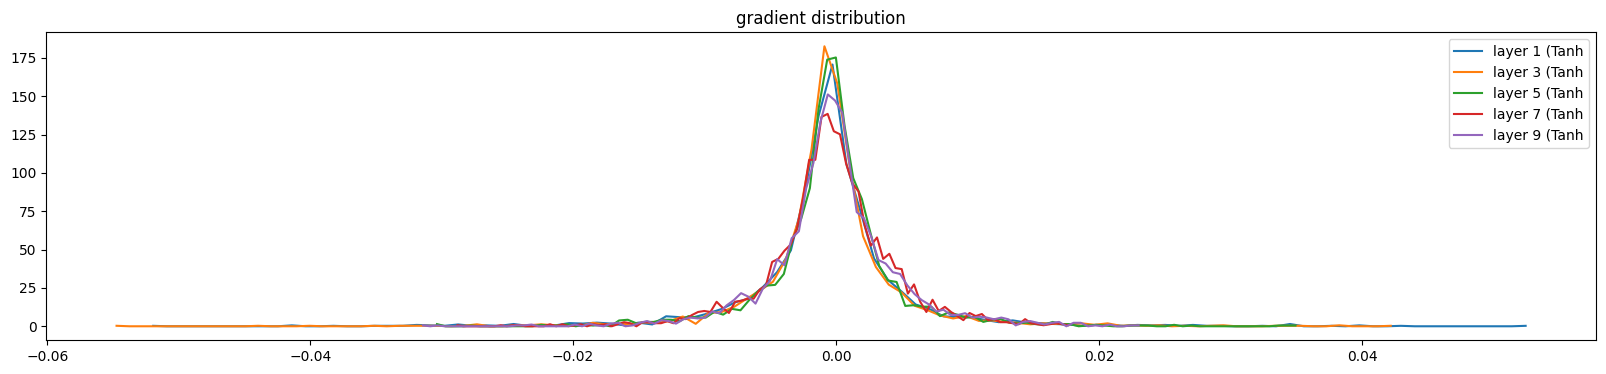

In [157]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

Plot update ratios over time - 

* Check the size of update! 
* Ensure update ratios > `-3`
* If < `-3`, params are not learning fast enough (LR too low)


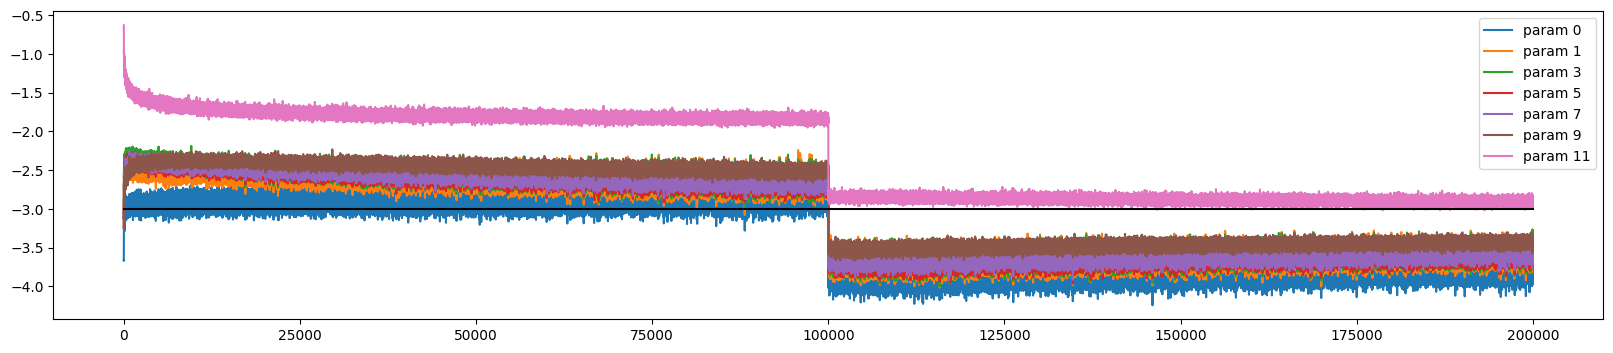

In [158]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);